<a href="https://colab.research.google.com/github/knc6/jarvis/blob/master/jarvis/colab/jarvis_ml_quick_train_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JARVIS-ML model training example

## Contents:
- Example of making descriptors: Coulomb matrix and Classical Force-field Inspired Descriptors (CFID)
- Training 500 formation energies
- fit-predict method in scikit-learn and other packages
- Learning curve, under and over-fitting, test-data validation
- Linear vs Gradient boosting models
- Feature importance analysis
- t-SNE manifold visualization


In [0]:
!pip install -U jarvis-tools lightgbm

In [2]:
from jarvis.sklearn.get_desc import get_comp_descp
from jarvis.sklearn.coulomb_mat import coulomb_matrix
from jarvis.sklearn.simple_models import bar_plot
import numpy as np
from sklearn.model_selection import train_test_split
from jarvis.sklearn.build_models import jdata, regr_scores, run, get_lgbm, plot_learning_curve
import matplotlib, pprint
%matplotlib inline
import matplotlib.pyplot as plt
from jarvis.db.static.explore_db import get_3d_dataset,get_2d_dataset,get_ml_dataset
import lightgbm as lgb
from sklearn.linear_model import LinearRegression


WARNING!!!!: LightGBM is not installed, using sklearn GBM


### Publications: https://www.ctcms.nist.gov/~knc6/pubs.html
### NIST-disclaimer: https://www.nist.gov/disclaimer

### For ML, we require data and descriptors. Below, we see examples of getting descriptors for an arbitrary material. The Coulomb matrix requires the material to be primitive cell (smallest possible cell) and uses atomic number and interatomic distances. The CFID descriptor uses radial, angle, dihedral, nearest-neighbor distribution, average elemental chemical properties for the cell, and average charge descriptors. CFID should be identical or very similar for supercells, primitive cells, and conventional cells of a material. There are various other dedicated softwares for making descriptors as well such as: Matminer (https://github.com/hackingmaterials/matminer), Dscribe (https://github.com/SINGROUP/dscribe) etc.

In [0]:
dat_3d = get_ml_dataset()

In [4]:
test_cfid_desc = get_comp_descp(dat_3d[0]['strt'])
print ('CFID',len(test_cfid_desc))
cfid_names = get_comp_descp(dat_3d[0]['strt'],print_names = True)
print ('CFID names',len(cfid_names))
test_coul_desc = coulomb_matrix(strt=dat_3d[0]['strt'],max_dim=100)
print ('Coulomb',len(test_coul_desc))

CFID 1557
CFID names 1557
Coulomb 100


In [0]:
#print (cfid_names)

## Exploring the data: the ML dataset consists of DFT calculated data, structure, and CFID descriptors (1557 length) for each material.

In [6]:
# Size of the data
len(dat_3d)

24759

In [0]:
#Available keys

In [8]:
dat_3d[0].keys()

dict_keys(['gv', 'mpid', 'hl_mass_z', 'hl_mass_y', 'hl_mass_x', 'op_gap', 'encut', 'form_enp', 'strt', 'mbj_gap', 'jid', 'el_mass_z', 'el_mass_x', 'el_mass_y', 'kp_leng', 'epsz', 'epsx', 'epsy', 'multi_elastic', 'type', 'fin_enp', 'el_mass', 'desc', 'magmom', 'exfoliation_en', 'hl_mass', 'mepsz', 'mepsx', 'mepsy', 'kv'])

### Exerceise: pprint: pretty printer of JSON https://docs.python.org/3.2/library/pprint.html#

In [9]:
"""
pprint.pprint(dat_3d[0])
"""

'\npprint.pprint(dat_3d[0])\n'

In [0]:
# desc: 1557 descriptors
# form_enp: formation energy per atom (eV/atom)
# op_gap: OptB88vdW functional based bandgap (eV)
# mbj_gap: TBmBJ functional based bandgap (eV)
# kv: Voigt bulk mod. (GPa)
# gv: Shear bulk mod. (GPa)
# elastic: elastic tensor instring format, use the function 'get_et' to convert into pymatgen elastictensor object
# epsx: Static dielctric function value in x-direction based on OptB88vdW (no unit)
# mepsx: Static dielctric function value in x-direction based on TBmBJ (no unit)
# magmom: Magnetic moment (Bohr magneton) [from OUTCAR and from OSZICAR], generally OSZICAR value is preferred
# kp_leng: Kpoint automatic line density obtained after automatic convergence (Angstrom), substract 25 because 5 extra points were taken during convergence
# encut: Plane wave cut-off value obtained after automatic convergence
# exfoliation_en: exfoliation energy
# strt: final structure after relaxation with OptB88vdW
# el/hl_mass: effective mass with BoltzTrap at 300K for electrons/holes
#'na' signifies non-available data

In [11]:
#Avilable data 
keys=['gv','kv','fin_enp','op_gap','mbj_gap','magmom','epsx','epsy','epsz','mepsx','mepsy','mepsz','hl_mass','form_enp','exfoliation_en']
info={}
for i in dat_3d:
  for j in keys:
     if i[j]!='na' and i[j]!={}:
            info.setdefault(j, []).append(i['jid'])
for i,j in info.items():
    print (i,len(j))


fin_enp 24759
op_gap 22394
magmom 24759
hl_mass 19978
form_enp 24759
mbj_gap 7055
mepsx 10560
mepsy 10560
mepsz 10560
exfoliation_en 564


# Quick ML training example for formation energy

### The "jdata" module gives descriptors and target data from the JARVIS-ML dataset (takes a while)

In [12]:
x,y,jid=jdata(prop='form_enp')

Prop= form_enp 24759 24759


## Let's train a simple linear regression model first : https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html

In [0]:
model = LinearRegression()


##We split the data into train and test sets. We can train the model with the train-data and predict using ML model for the test data.

In [14]:
X_train, X_test, y_train, y_test,jid_train,jid_test = train_test_split(x, y,jid, random_state=1, test_size=0.1)
print (len(X_train), len(X_test))


22283 2476


##Let's take 500 of training set as a quick example

In [15]:
X1=X_train[0:500]
Y1=y_train[0:500]
X2=X_test[0:500]
Y2=y_test[0:500]
print (X1.shape)


(500, 1557)


## Scikit-learn and related ML models have "fit" and "predict" methods. 

In [16]:
model.fit(X1,Y1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Let's predict for the held data

In [0]:
pred=model.predict(X2)

###The "regr_score" function gives regression relation metrics data

Text(0, 0.5, 'ML-Formation energy (eV/atom)')

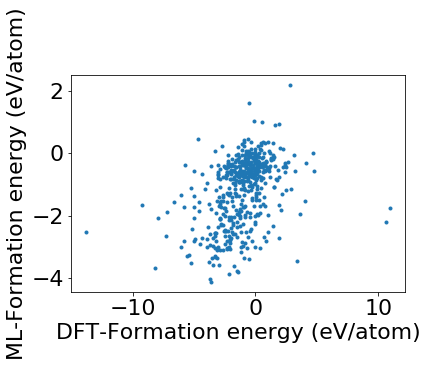

In [18]:
reg_sc=regr_scores(Y2,pred)
plt.plot(reg_sc['test'],reg_sc['pred'],'.')
plt.xlabel('DFT-Formation energy (eV/atom)')
plt.ylabel('ML-Formation energy (eV/atom)')

###Let's plot learning curve to see whether the model improves as we add more data. Also, this helps in guessing whether the model is under vs overfitting.

See also: https://towardsdatascience.com/holy-grail-for-bias-variance-tradeoff-overfitting-underfitting-7fad64ab5d76

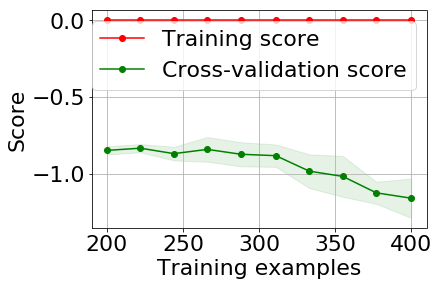

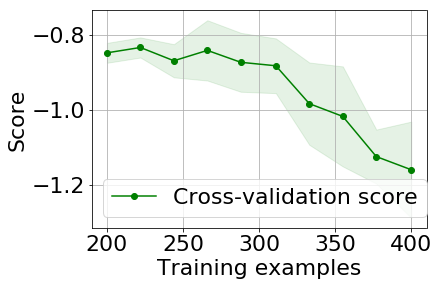

{'test_scores_mean': array([-0.84862532, -0.83428236, -0.86971367, -0.84205476, -0.87384708,
        -0.88306234, -0.98412703, -1.01815822, -1.12528757, -1.16044333]),
 'test_scores_std': array([0.02654085, 0.02682818, 0.04419794, 0.08041249, 0.07859878,
        0.07301228, 0.10978655, 0.13339467, 0.07202428, 0.1284626 ]),
 'train_scores_mean': array([-2.47578325e-11, -1.49290711e-11, -1.42649371e-11, -1.74809690e-11,
        -4.32416496e-11, -1.40712572e-11, -1.89909853e-11, -1.48630793e-11,
        -2.08317095e-11, -2.93929010e-11]),
 'train_scores_std': array([1.45753591e-11, 3.15604291e-12, 4.15362228e-12, 1.84065909e-11,
        2.93122053e-11, 9.84157158e-12, 1.27522227e-11, 1.08984119e-11,
        1.21755951e-11, 1.63047922e-11]),
 'train_sizes': array([200, 222, 244, 266, 288, 311, 333, 355, 377, 400])}

In [19]:
plot_learning_curve(estimator=model,X=X1,y=Y1,train_sizes=np.linspace(0.5, 1.0, 10))

# Now let's try LightGBM model.

Text(0, 0.5, 'ML-Formation energy (eV/atom)')

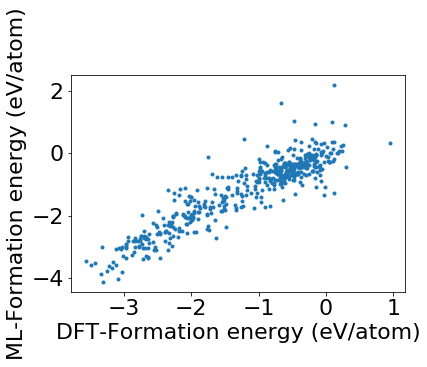

In [20]:

model = lgb.LGBMRegressor(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=5,
                    num_leaves=100,
                    objective='regression',
                    n_jobs=-1,
                    verbose=-1
                   )

model.fit(X1,Y1)
pred=model.predict(X2)
reg_sc=regr_scores(Y2,pred)
plt.plot(reg_sc['test'],reg_sc['pred'],'.')
plt.xlabel('DFT-Formation energy (eV/atom)')
plt.ylabel('ML-Formation energy (eV/atom)')

###Let's plot learning curve to see whether the model improves as we add more data. Also, this helps in guessing whether the model is under vs overfitting.

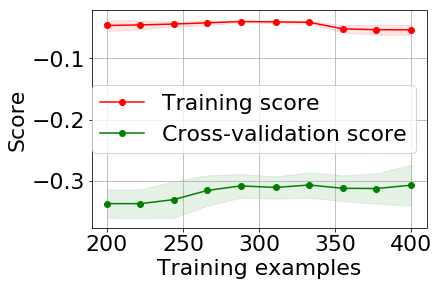

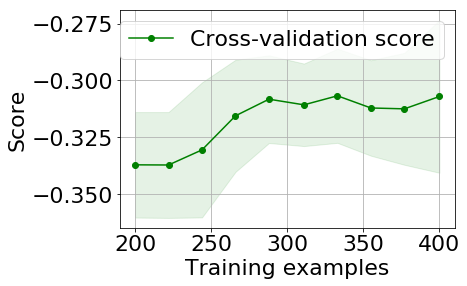

{'test_scores_mean': array([-0.33709027, -0.33716226, -0.33053044, -0.31555346, -0.3082518 ,
        -0.31072502, -0.30676033, -0.31211315, -0.31248712, -0.30706288]),
 'test_scores_std': array([0.02317431, 0.02325632, 0.02967293, 0.02462823, 0.01924897,
        0.0181268 , 0.02067401, 0.0209747 , 0.02458953, 0.03350736]),
 'train_scores_mean': array([-0.04661633, -0.04566734, -0.04427018, -0.04230299, -0.04015368,
        -0.04075912, -0.04142096, -0.05212321, -0.05348415, -0.05369933]),
 'train_scores_std': array([0.00853676, 0.00741463, 0.00387287, 0.00422703, 0.00089438,
        0.00212943, 0.00234468, 0.00588187, 0.0080831 , 0.00803755]),
 'train_sizes': array([200, 222, 244, 266, 288, 311, 333, 355, 377, 400])}

In [21]:
plot_learning_curve(estimator=model,X=X1,y=Y1,train_sizes=np.linspace(0.5, 1.0, 10))

### Percentage feature importances

In [22]:
#See https://github.com/usnistgov/jarvis/blob/master/jarvis/sklearn/build_models.py

feat_imp = model.feature_importances_  # feature_importances_
feat_imp = 100*np.array([float(i) / float(np.sum(feat_imp)) for i in feat_imp])
print (feat_imp)

[0.10214505 0.         0.20429009 ... 0.20429009 0.20429009 0.20429009]


In [0]:
importance_names = list(sorted(zip(feat_imp,cfid_names),reverse=True))

### Pie-chart for the feature imporatnce

In [0]:
imp_rdf = 0
imp_nn = 0
imp_adfa = 0
imp_adfb = 0
imp_ddf = 0
imp_chg = 0
imp_chem = 0
imp_cell = 0
tmp = []
colors = [
    "yellowgreen",
    "gold",
    "lightskyblue",
    "lightcoral",
    "lightblue",
    "lightgreen",
    "olive",
    "tomato",
]
for i in importance_names:
    imp = i[0]
    nm = i[1]
    if "chg" in nm:
        imp_chg = imp_chg + imp
    elif "cell" in nm:
        imp_cell = imp_cell + imp
    elif "nn" in nm:
        imp_nn = imp_nn + imp
    elif "rdf" in nm:
        imp_rdf = imp_rdf + imp
    elif "adfa" in nm:
        imp_adfa = imp_adfa + imp
    elif "ddf" in nm:
        imp_ddf = imp_ddf + imp
    elif "adfb" in nm:
        imp_adfb = imp_adfb + imp
    else:
        imp_chem = imp_chem + imp



([<matplotlib.patches.Wedge at 0x7f2a6b4b5c18>,
 [Text(-1.0652832851551657, -0.2741742554818341, 'Chem'),
  Text(0.9205781832057778, -0.6021094656335754, 'RDF'),
  Text(1.0844264240465953, 0.18444329976855833, 'NN'),
  Text(0.9319997640596288, 0.584274284726614, 'ADF-a'),
  Text(0.798134501269043, 0.7569552945082135, 'ADF-b'),
  Text(0.6641401819240386, 0.8768795919360337, 'DDF'),
  Text(0.35699369960875427, 1.0404592728404387, 'Charge'),
  Text(0.0599782050271279, 1.0983636077919388, 'Cell-para')],
 [Text(-0.5810636100846358, -0.14954959389918224, '58.0%'),
  Text(0.5021335544758787, -0.3284233448910411, '15.5%'),
  Text(0.5915053222072337, 0.10060543623739544, '8.3%'),
  Text(0.5083635076688884, 0.3186950643963349, '4.2%'),
  Text(0.4353460916012961, 0.41288470609538913, '2.1%'),
  Text(0.36225828104947555, 0.4782979592378365, '3.1%'),
  Text(0.19472383615022956, 0.5675232397311484, '7.0%'),
  Text(0.032715384560251574, 0.5991074224319666, '1.7%')])

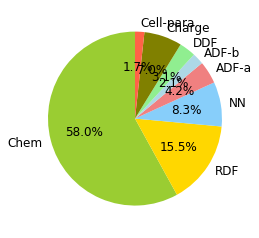

In [25]:
labels=['Chem','RDF','NN','ADF-a','ADF-b','DDF','Charge','Cell-para']
values=[imp_chem,imp_rdf,imp_nn,imp_adfa,imp_adfb,imp_ddf,imp_chg,imp_cell]
plt.rcParams['font.size'] = 12.0
plt.pie(values,labels=labels,autopct='%1.1f%%', startangle=90,colors=colors)

### Top 10 most and least important features

In [26]:
print ('Most important',importance_names[0:10])

Most important [(2.3493360572012256, 'C-16'), (2.247191011235955, 'ndvalence'), (1.7364657814096014, 'rdf_89'), (1.5321756894790604, 'min_oxid_s'), (1.2257405515832482, 'first_ion_en_add_voro_coord'), (1.1235955056179776, 'hfus_divi_voro_coord'), (0.9193054136874361, 'rdf_76'), (0.9193054136874361, 'polzbl_mult_mp'), (0.9193054136874361, 'nn_88'), (0.8171603677221655, 'polzbl_mult_bp')]


In [27]:
print ('Least important',importance_names[-10:])

Least important [(0.0, 'C-22'), (0.0, 'C-20'), (0.0, 'C-19'), (0.0, 'C-18'), (0.0, 'C-17'), (0.0, 'C-15'), (0.0, 'C-13'), (0.0, 'C-12'), (0.0, 'C-11'), (0.0, 'C-1')]


### Visualization with manifold t-SNE
### Compare several manifold techniques: https://scikit-learn.org/stable/auto_examples/manifold/plot_compare_methods.html#sphx-glr-auto-examples-manifold-plot-compare-methods-py

In [28]:
from sklearn import decomposition,manifold
pca = decomposition.PCA(n_components=30)
Z_pca = pca.fit_transform(X1)
sne = manifold.TSNE(perplexity=.1, verbose=True)
sne.fit(Z_pca)

[t-SNE] Computing 1 nearest neighbors...
[t-SNE] Indexed 500 samples in 0.001s...
[t-SNE] Computed neighbors for 500 samples in 0.005s...
[t-SNE] Computed conditional probabilities for sample 500 / 500
[t-SNE] Mean sigma: 0.812962
[t-SNE] KL divergence after 250 iterations with early exaggeration: 89.973427
[t-SNE] KL divergence after 1000 iterations: 0.435147


TSNE(angle=0.5, early_exaggeration=12.0, init='random', learning_rate=200.0,
     method='barnes_hut', metric='euclidean', min_grad_norm=1e-07,
     n_components=2, n_iter=1000, n_iter_without_progress=300, perplexity=0.1,
     random_state=None, verbose=True)

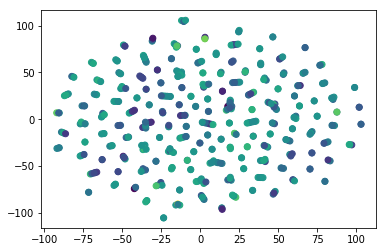

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.scatter(sne.embedding_[:,0],sne.embedding_[:,1],c=Y1)
plt.show()

### Exercise: redo the above exercise for op_gap instead of form_enp

### Exercise: plot feature-corrleations using Seaborn https://seaborn.pydata.org/examples/heatmap_annotation.html